### Phase analysis - General Approach

Example for pairs composed of F1 (83) channel

In [1]:
import sys

sys.path.insert(1, "/home/vinicius/storage1/projects/phase_coupling_analysis")

In [2]:
import os

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pycircular
import scipy
import seaborn as sns
import xarray as xr
from scipy.signal import find_peaks
from scipy.stats import circmean, circstd, circvar
from sklearn.metrics import euclidean_distances
from tqdm import tqdm
from xarray_einstats.stats import circmean, circstd

from frites.conn import conn_reshape_undirected
from src.signal.surrogates import trial_swap_surrogates
from src.util import _extract_roi

In [3]:
def circular_hist(
    ax, x, bins=16, density=True, offset=0, gaps=True, fill=False, alpha=0.3, color="b"
):
    """
    Produce a circular histogram of angles on ax.

    Parameters
    ----------
    ax : matplotlib.axes._subplots.PolarAxesSubplot
        axis instance created with subplot_kw=dict(projection='polar').

    x : array
        Angles to plot, expected in units of radians.

    bins : int, optional
        Defines the number of equal-width bins in the range. The default is 16.

    density : bool, optional
        If True plot frequency proportional to area. If False plot frequency
        proportional to radius. The default is True.

    offset : float, optional
        Sets the offset for the location of the 0 direction in units of
        radians. The default is 0.

    gaps : bool, optional
        Whether to allow gaps between bins. When gaps = False the bins are
        forced to partition the entire [-pi, pi] range. The default is True.

    Returns
    -------
    n : array or list of arrays
        The number of values in each bin.

    bins : array
        The edges of the bins.

    patches : `.BarContainer` or list of a single `.Polygon`
        Container of individual artists used to create the histogram
        or list of such containers if there are multiple input datasets.
    """
    # Wrap angles to [-pi, pi)
    x = (x + np.pi) % (2 * np.pi) - np.pi

    # Force bins to partition entire circle
    if not gaps:
        bins = np.linspace(-np.pi, np.pi, num=bins + 1)

    # Bin data and record counts
    n, bins = np.histogram(x, bins=bins)

    # Compute width of each bin
    widths = np.diff(bins)

    # By default plot frequency proportional to area
    if density:
        # Area to assign each bin
        area = n / x.size
        # Calculate corresponding bin radius
        radius = (area / np.pi) ** 0.5
    # Otherwise plot frequency proportional to radius
    else:
        radius = n

    # Plot data on ax
    patches = ax.bar(
        bins[:-1],
        radius,
        zorder=1,
        align="edge",
        width=widths,
        edgecolor="k",
        fill=fill,
        linewidth=1,
        alpha=alpha,
        color=color,
    )

    # Set the direction of the zero angle
    ax.set_theta_offset(offset)

    # Remove ylabels for area plots (they are mostly obstructive)
    if density:
        ax.set_yticks([])

    return n, bins, patches

In [4]:
def detect_peak_frequencies(power=None, prominence=0.01, verbose=False):

    assert power.ndim == 2
    assert isinstance(power, xr.DataArray)

    roi, freqs = power.roi.data, power.freqs.data
    n_roi = len(roi)

    rois = []
    peak_freqs = []
    peak_prominences = []

    __iter = range(n_roi)
    for i in tqdm(__iter) if verbose else __iter:
        peak_index, peak_info = find_peaks(power[i, :], prominence=prominence)
        peak_freqs += [freqs[peak_index]]
        peak_prominences += [peak_info["prominences"]]
        rois += [[roi[i]] * len(peak_index)]

    return peak_freqs, peak_prominences, rois

In [5]:
def find_start_end(array, find_zeros=False):
    """
    Given a binary array find the indexes where the sequences of ones start
    and begin if find_zeros is False. Otherwise it will find the indexes where
    the sequences of zeros start and begin. For instance, for the array
    [0,1,1,1,0,0], would return 1 and 3 respectively for find_zeros=False,
    and 1 and 2 for find_zeros=True.

    Parameters
    ----------
    array: array_like
        Binary array.
    find_zeros: bool | False
        Wheter to find a sequence of zeros or ones

    Returns
    -------
    The matrix containing the start anb ending index
    for each sequence of consecutive ones or zeros with shapes [n_seqs,2]
    where n_seqs is the number of sequences found.
    """
    if find_zeros:
        _bounds = np.array([1])
    else:
        _bounds = np.array([0])

    bounded = np.hstack((_bounds, array, _bounds))
    difs = np.diff(bounded)
    # get 1 at run starts and -1 at run ends if find_zeros is False
    if not find_zeros:
        (run_starts,) = np.where(difs > 0)
        (run_ends,) = np.where(difs < 0)
    # get -1 at run starts and 1 at run ends if find_zeros is True
    else:
        (run_starts,) = np.where(difs < 0)
        (run_ends,) = np.where(difs > 0)
    return np.vstack((run_starts, run_ends)).T


def find_activation_sequences(spike_train, find_zeros=False, dt=None, pad=False):
    """
    Given a spike-train, it finds the length of all activations in it.
    For example, for the following spike-train: x = {0111000011000011111},
    the array with the corresponding sequences of activations (ones) will be
    returned: [3, 2, 5] (times dt if this parameter is provided).

    Parameters
    ----------
    spike_train: array_like
        The binary spike train.
    find_zeros: bool | False
        Wheter to find a sequence of zeros or ones
    dt: int | None
        If provided the returned array with the length of activations
        will be given in seconds.

    Returns
    -------
    act_lengths: array_like
        Array containing the length of activations with shape [n_seqs]
        where n_seqs is the number of sequences found.
    """

    # If no dt is specified it is set to 1
    if dt is None:
        dt = 1
    out = find_start_end(spike_train, find_zeros=find_zeros)
    act_lengths = (out[:, 1] - out[:, 0]) * dt

    if pad:
        _new_size = len(spike_train) // 2 + 1
        act_lengths = _nan_pad(act_lengths, _new_size, 0)

    return act_lengths

#### Load data

In [6]:
DATA_PATH = os.path.expanduser(
    "/home/vinicius/funcog/phaseanalysis/Results/lucy/141017"
)


def load_channel_pair(path2data: str, roi_a: str, roi_b: str, band: int):

    average_power_epochs = xr.load_dataarray(
        os.path.join(DATA_PATH, "average_power.nc")
    )

    power_time_series = xr.open_dataarray(
        os.path.join(DATA_PATH, f"power_time_series_band_{band}_surr_False.nc")
    )

    phase_time_series = xr.open_dataarray(
        os.path.join(DATA_PATH, f"phase_time_series_band_{band}_surr_False.nc")
    )

    phi_series = xr.open_dataarray(
        os.path.join(
            DATA_PATH, f"phase_difference_time_series_band_{band}_surr_False.nc"
        )
    )

    # phi_series_surr = xr.open_dataarray(
    #    os.path.join(DATA_PATH, f"phase_difference_time_series_band_{band}_surr_True.nc")
    # )

    power_time_series = power_time_series.sel(roi=[roi_a, roi_b]).load()
    phase_time_series = phase_time_series.sel(roi=[roi_a, roi_b]).load()
    phi_series = phi_series.sel(roi=[f"{roi_a}-{roi_b}"]).load()
    # phi_series_surr = phi_series_surr.sel(roi=[f"{roi_a}-{roi_b}"]).load()

    return power_time_series, phase_time_series, phi_series  # , phi_series_surr

In [7]:
roi_a, roi_b = (
    "F2_36",
    "V1_248",
)

power_time_series, phi_series = [], []

for band in tqdm(range(16)):
    out = load_channel_pair(DATA_PATH, roi_a, roi_b, band)
    power_time_series += [out[0]]
    phi_series += [out[2]]

100%|████████████████████████████████████████████████████████████████████████████| 16/16 [00:04<00:00,  3.58it/s]


In [8]:
power_time_series = xr.concat(power_time_series, "freqs")
phi_series = xr.concat(phi_series, "freqs")

In [9]:
freqs = np.array([5, 10, 15, 20, 25, 30, 35, 40, 45, 50, 55, 60, 65, 70, 75, 80])

#### Compute power envelope correlations

In [10]:
from frites.conn.conn_utils import conn_links
from frites.utils import parallel_func


def shuffle_along_axis(a, axis):
    idx = np.random.rand(*a.shape).argsort(axis=axis)
    return np.take_along_axis(a, idx, axis=axis)


def _int(w, x_s, x_t, kw_para):

    # define the power envelope correlations
    def pairwise_int(w_x, w_y):
        # computes fraciton of events above threshold that intersect
        x = w[:, w_x, :, :]
        y = w[:, w_y, :, :]
        prod = x * y
        norm = np.max([x.sum(-1), y.sum(-1)], axis=0)
        norm = np.where(norm == 0, 1, norm)
        return prod

    # define the function to compute in parallel
    parallel, p_fun = parallel_func(pairwise_int, **kw_para)

    # compute the single trial power envelope correlations
    return parallel(p_fun(s, t) for s, t in zip(x_s, x_t))


def power_events_coincidence(
    power, q_l, q_u=None, n_jobs=1, verbose=False, shuffle=False
):

    # Extract dimensions
    dims = power.dims
    trials, roi, freqs = power.trials.data, power.roi.data, power.freqs.data
    ntrials, nroi, nfreqs, ntimes = power.shape

    roi_gp, roi_idx = roi, np.arange(nroi).reshape(-1, 1)
    (x_s, x_t), roi_p = conn_links(roi_gp, {})
    n_pairs = len(x_s)

    quantiles = power.quantile(q_l, "times")

    z_power = (power >= quantiles).values

    if isinstance(q_u, float):
        quantiles = power.quantile(q_u, "times")
        z_power = np.logical_and(z_power, power < quantiles).values

    if shuffle:
        z_power = shuffle_along_axis(z_power, 0)

    kw_para = dict(n_jobs=n_jobs, verbose=verbose, total=n_pairs)

    pec = _int(z_power, x_s, x_t, kw_para)
    pec = np.stack(pec, axis=1)

    # conversion
    pec = xr.DataArray(
        pec,
        dims=dims,
        name="pec",
        coords={"trials": trials, "roi": roi_p, "freqs": freqs},
    )

    return pec

In [11]:
pec = power_events_coincidence(power_time_series, 0.6)

Defining links (n_roi=2; directed={}; net=False, nb_min_links=None)
    Sorting roi names


  0%|          |  : 0/1 [00:00<?,       ?it/s]

In [12]:
pec_shuffle = power_events_coincidence(power_time_series, 0.6, shuffle=True)

Defining links (n_roi=2; directed={}; net=False, nb_min_links=None)
    Sorting roi names


  0%|          |  : 0/1 [00:00<?,       ?it/s]

#### Compute phase relations

In [13]:
filtered_phi_series = xr.DataArray(
    np.where(~pec, np.nan, phi_series),
    dims=phi_series.dims,
    coords=phi_series.coords,
)

In [14]:
edges = phi_series.roi.data

In [15]:
roi_s, roi_t = _extract_roi(edges, "-")

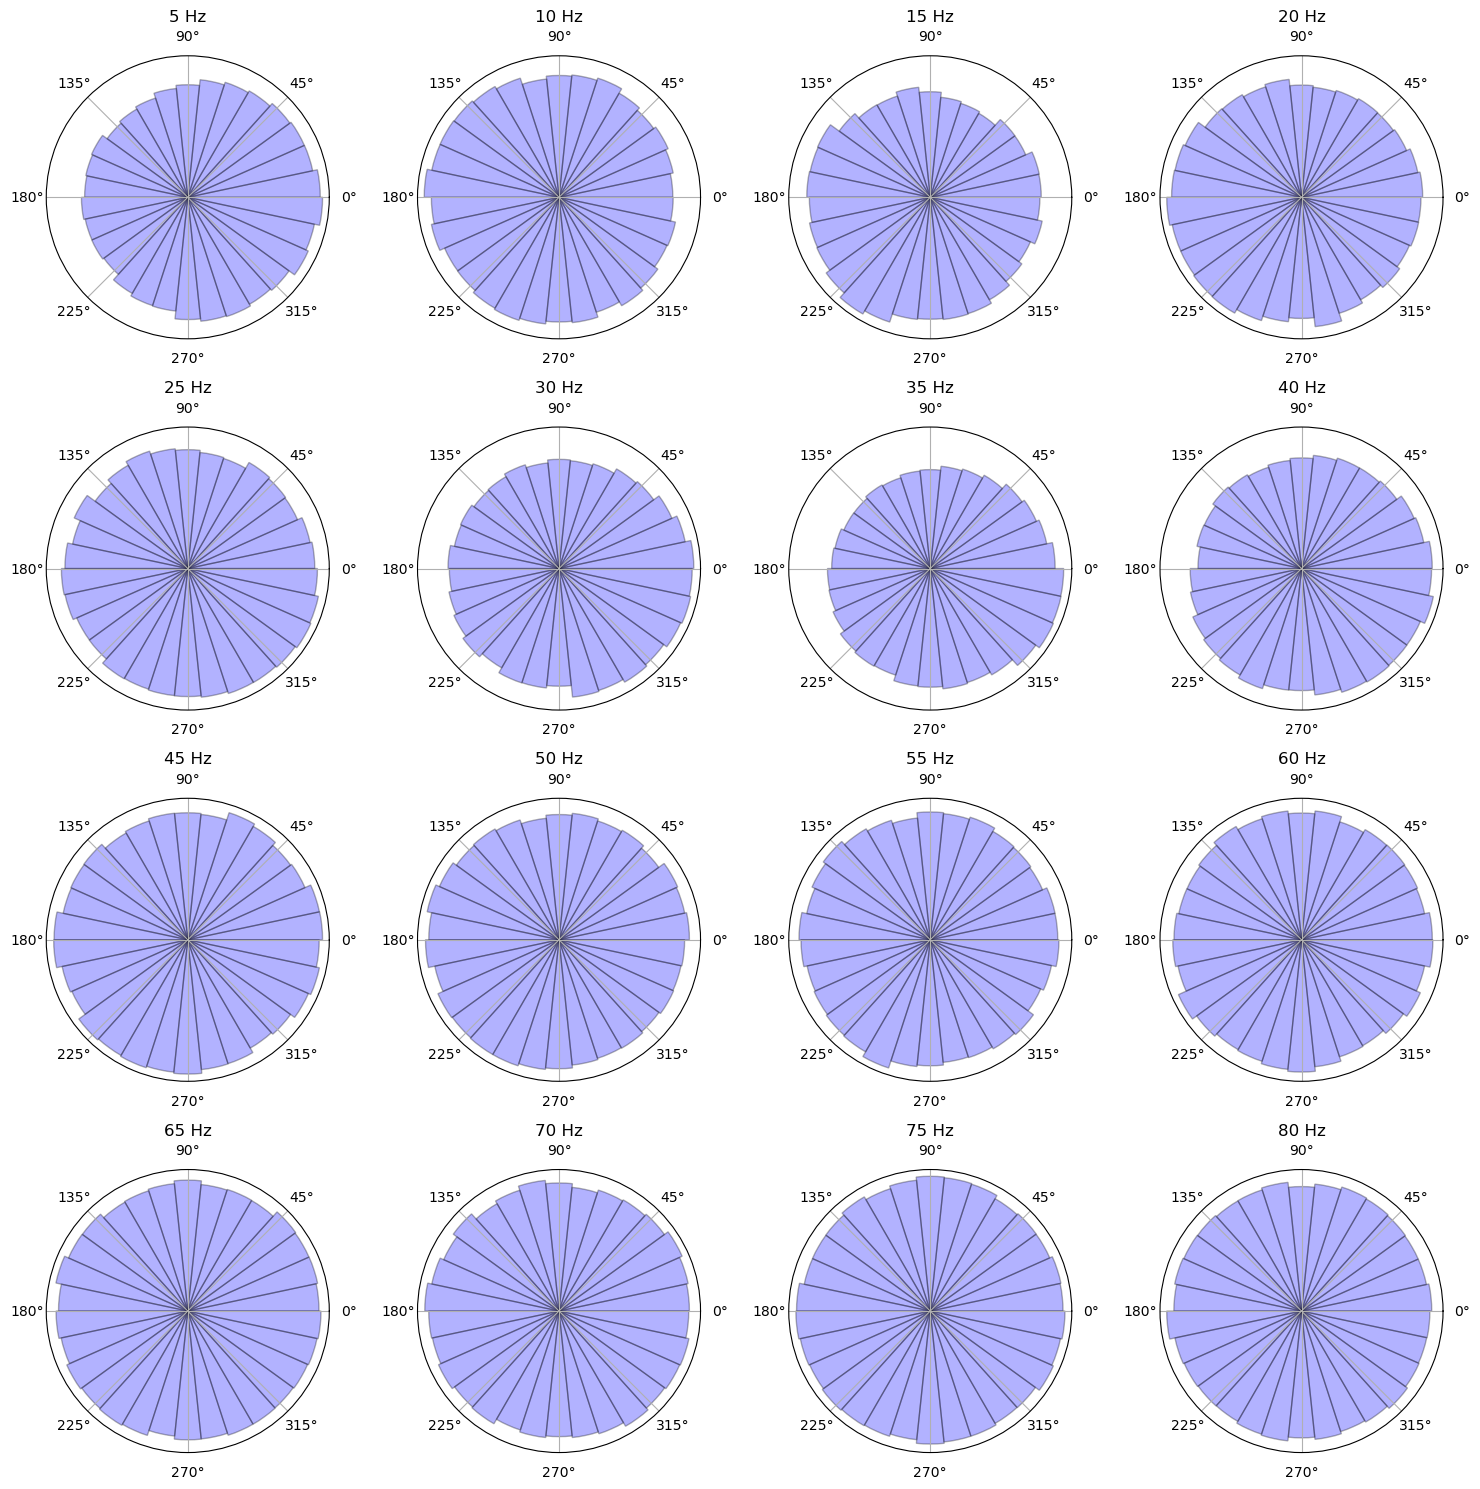

In [16]:
plt.figure(figsize=(15, 15))

for pp, freq in enumerate(pec.freqs.values):

    ax = plt.subplot(4, 4, pp + 1, projection="polar")

    out = filtered_phi_series.sel(freqs=freq).data.flatten()
    out = out[~np.isnan(out)]

    circular_hist(
        ax,
        out,
        bins=30,
        fill=True,
    )
    m_1, m_2 = pycircular.stats.periodic_mean_std(out.data)

    plt.title(f"{freqs[pp]} Hz")

plt.tight_layout()

In [17]:
x = filtered_phi_series.squeeze().data.flatten()
size = len(x[~np.isnan(x)])
# scipy.stats.circmean(scipy.stats.circstd( np.random.uniform(0, np.pi * 2, size=(size, 100)), axis=1))

In [18]:
phi_max = np.sqrt(np.log(size))

In [19]:
std = [
    scipy.stats.circstd(filtered_phi_series.isel(freqs=i), nan_policy="omit")
    for i in tqdm(range(len(freqs)))
]

std = xr.DataArray(std, dims="freqs", coords=(freqs,))

100%|████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<00:00, 16.81it/s]


Text(0.5, 1.0, 'F2_36 - V1_248')

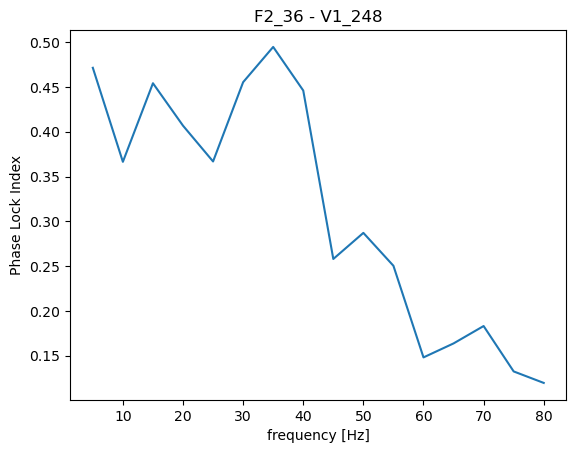

In [20]:
(1 - std / phi_max).plot(x="freqs")
plt.ylabel("Phase Lock Index")
plt.xlabel("frequency [Hz]")
plt.title(f"{roi_a} - {roi_b}")

#### Duration distributions

In [21]:
x = pec.squeeze()
d = np.zeros((398, 16))
for i in tqdm(range(398)):
    for k in range(16):
        d[i, k] = find_activation_sequences(x[i, k], dt=1).mean()

d = xr.DataArray(
    d,
    dims=("trials", "freqs"),
    coords=(pec.trials.values, freqs),
)

100%|█████████████████████████████████████████████████████████████████████████| 398/398 [00:01<00:00, 313.40it/s]


Text(0.5, 0.98, 'Burst duration statistics')

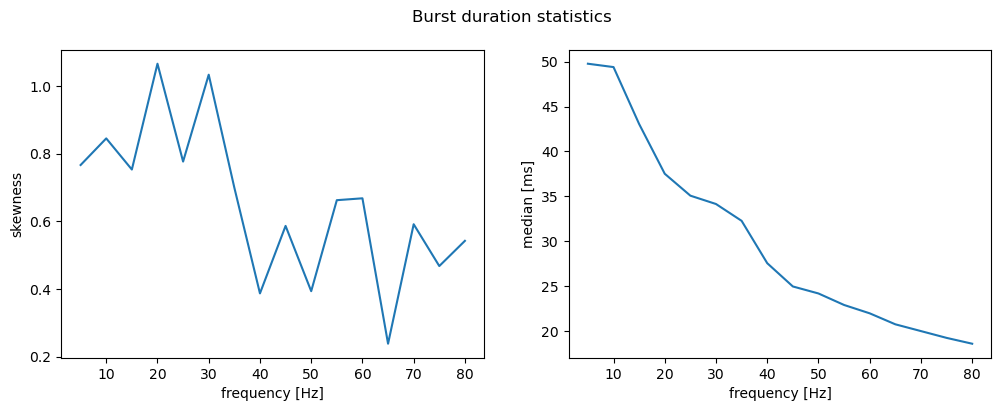

In [22]:
plt.figure(figsize=(12, 4))
plt.subplot(121)
plt.plot(freqs, scipy.stats.skew(d, axis=0))
plt.ylabel("skewness")
plt.xlabel("frequency [Hz]")
plt.subplot(122)
plt.plot(freqs, np.median(d, axis=0))
plt.ylabel("median [ms]")
plt.xlabel("frequency [Hz]")
plt.suptitle("Burst duration statistics")

#### F1 (83) Network

In [23]:
band = 12

average_power_epochs = xr.load_dataarray(os.path.join(DATA_PATH, "average_power.nc"))

power_time_series = xr.open_dataarray(
    os.path.join(DATA_PATH, f"power_time_series_band_{band}_surr_False.nc")
)

phase_time_series = xr.open_dataarray(
    os.path.join(DATA_PATH, f"phase_time_series_band_{band}_surr_False.nc")
)

phi_series = xr.open_dataarray(
    os.path.join(DATA_PATH, f"phase_difference_time_series_band_{band}_surr_False.nc")
)

In [24]:
roi_s, roi_t = _extract_roi(phi_series.roi.data, "-")

In [25]:
indexes = np.logical_or(roi_s == "F1_83", roi_t == "F1_83")

In [26]:
roi = np.unique((roi_s[indexes], roi_t[indexes]))

In [27]:
# phi_series_surr = xr.open_dataarray(
#    os.path.join(DATA_PATH, f"phase_difference_time_series_band_{band}_surr_True.nc")
# )

power_time_series = power_time_series.sel(roi=roi).load()
phase_time_series = phase_time_series.sel(roi=roi).load()
phi_series = phi_series.isel(roi=indexes).load()

In [28]:
pec = power_events_coincidence(power_time_series, 0.6).sel(roi=phi_series.roi.values)

Defining links (n_roi=82; directed={}; net=False, nb_min_links=None)
    Sorting roi names


  0%|          |  : 0/3321 [00:00<?,       ?it/s]

In [29]:
filtered_phi_series = xr.DataArray(
    np.where(~pec, np.nan, phi_series),
    dims=phi_series.dims,
    coords=phi_series.coords,
)

In [30]:
edges = phi_series.roi.data

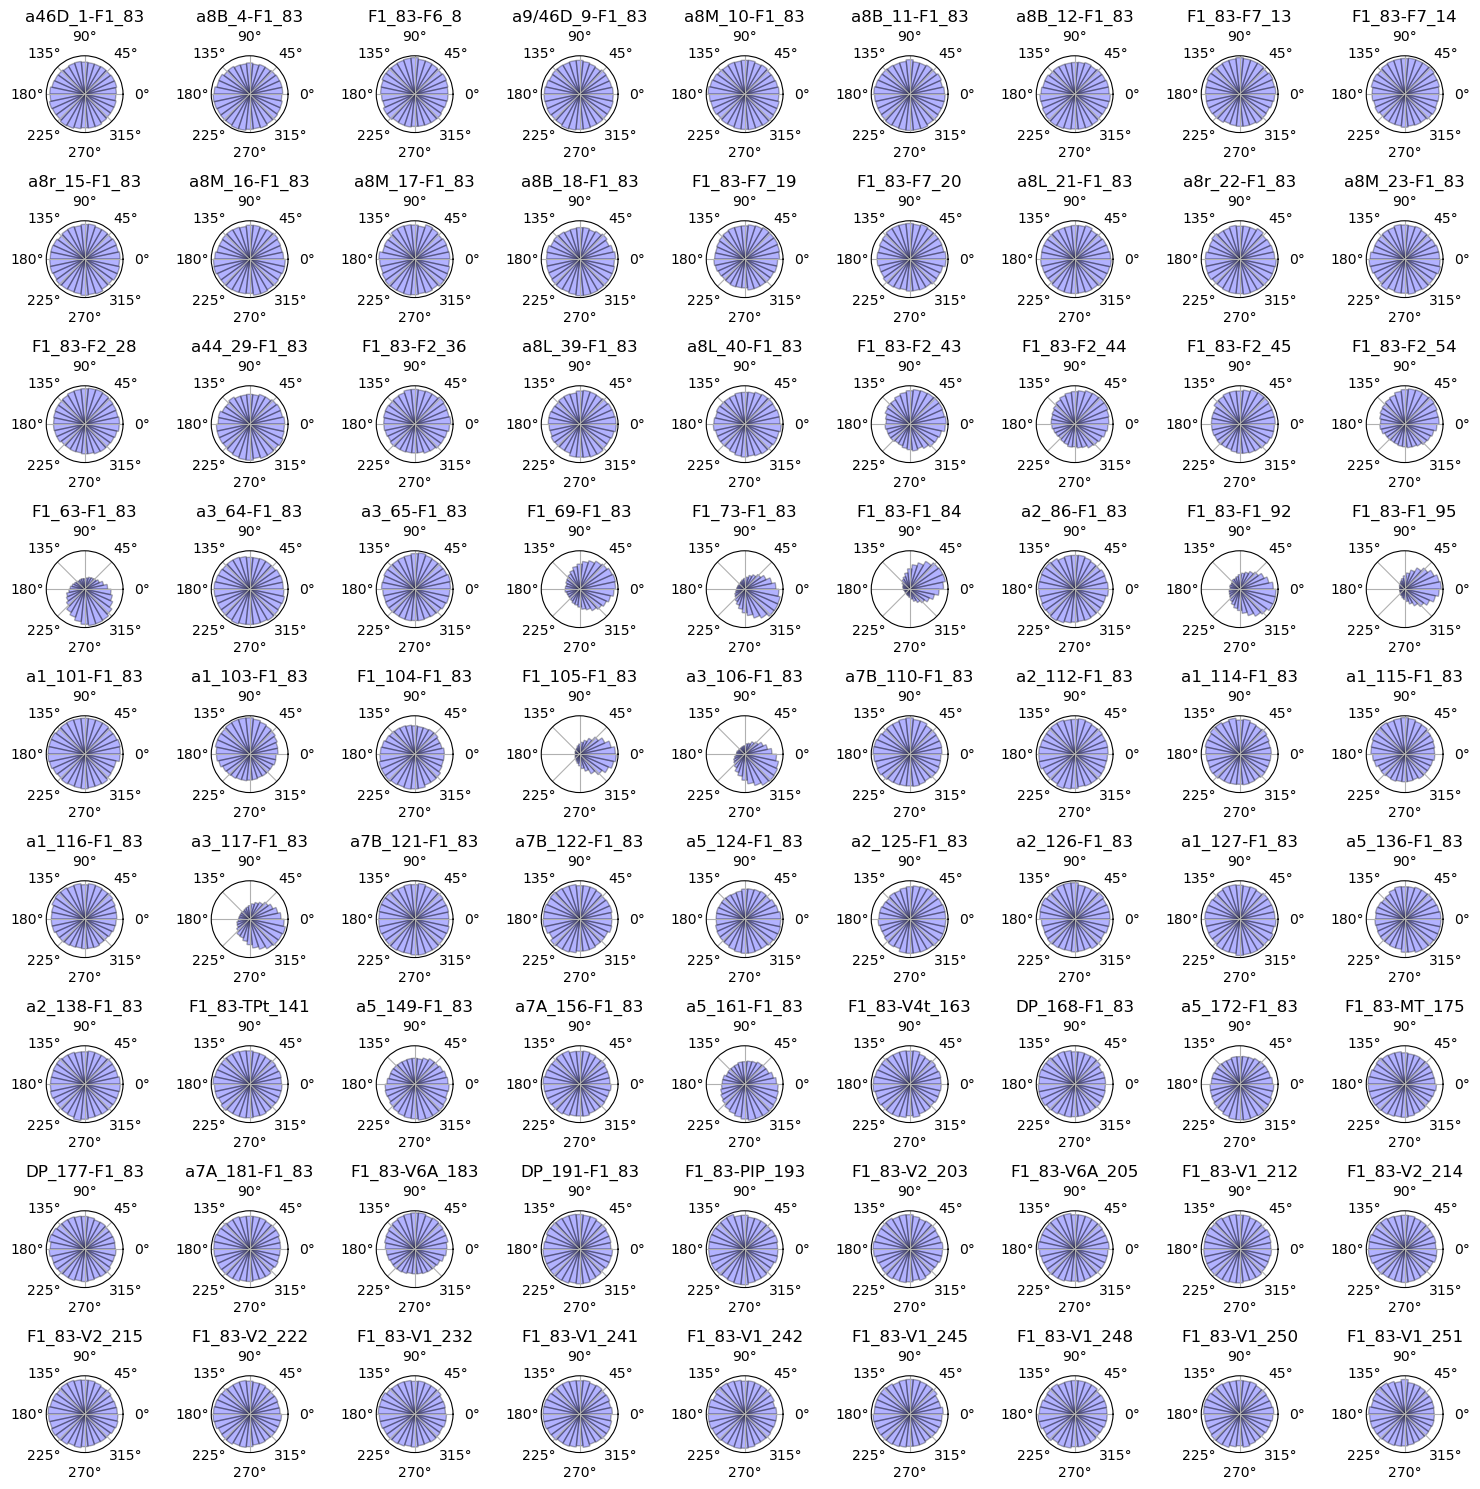

In [31]:
plt.figure(figsize=(15, 15))

mu, sig = [], []

for pp, roi in enumerate(pec.roi.values):

    ax = plt.subplot(9, 9, pp + 1, projection="polar")

    out = filtered_phi_series.sel(roi=roi).data.flatten()
    out = out[~np.isnan(out)]

    circular_hist(
        ax,
        out,
        bins=30,
        fill=True,
    )
    m_1, m_2 = pycircular.stats.periodic_mean_std(out.data)

    mu += [m_1]
    sig += [m_2]

    plt.title(roi)

plt.tight_layout()

plt.savefig(f"figures/band{band}/phase_distributions_F1_83_pairs.pdf")

In [32]:
mu = xr.DataArray(mu, dims=("roi"), coords=(edges,))
sig = xr.DataArray(sig, dims=("roi"), coords=(edges,))

In [33]:
x = pec.squeeze()
d = np.zeros((pec.sizes["trials"], pec.sizes["roi"]))
for i in tqdm(range(pec.sizes["trials"])):
    for k in range(pec.sizes["roi"]):
        d[i, k] = find_activation_sequences(x[i, k], dt=1).mean()

d = xr.DataArray(
    d,
    dims=("trials", "roi"),
    coords=(pec.trials.values, edges),
)

100%|██████████████████████████████████████████████████████████████████████████| 398/398 [00:06<00:00, 64.67it/s]


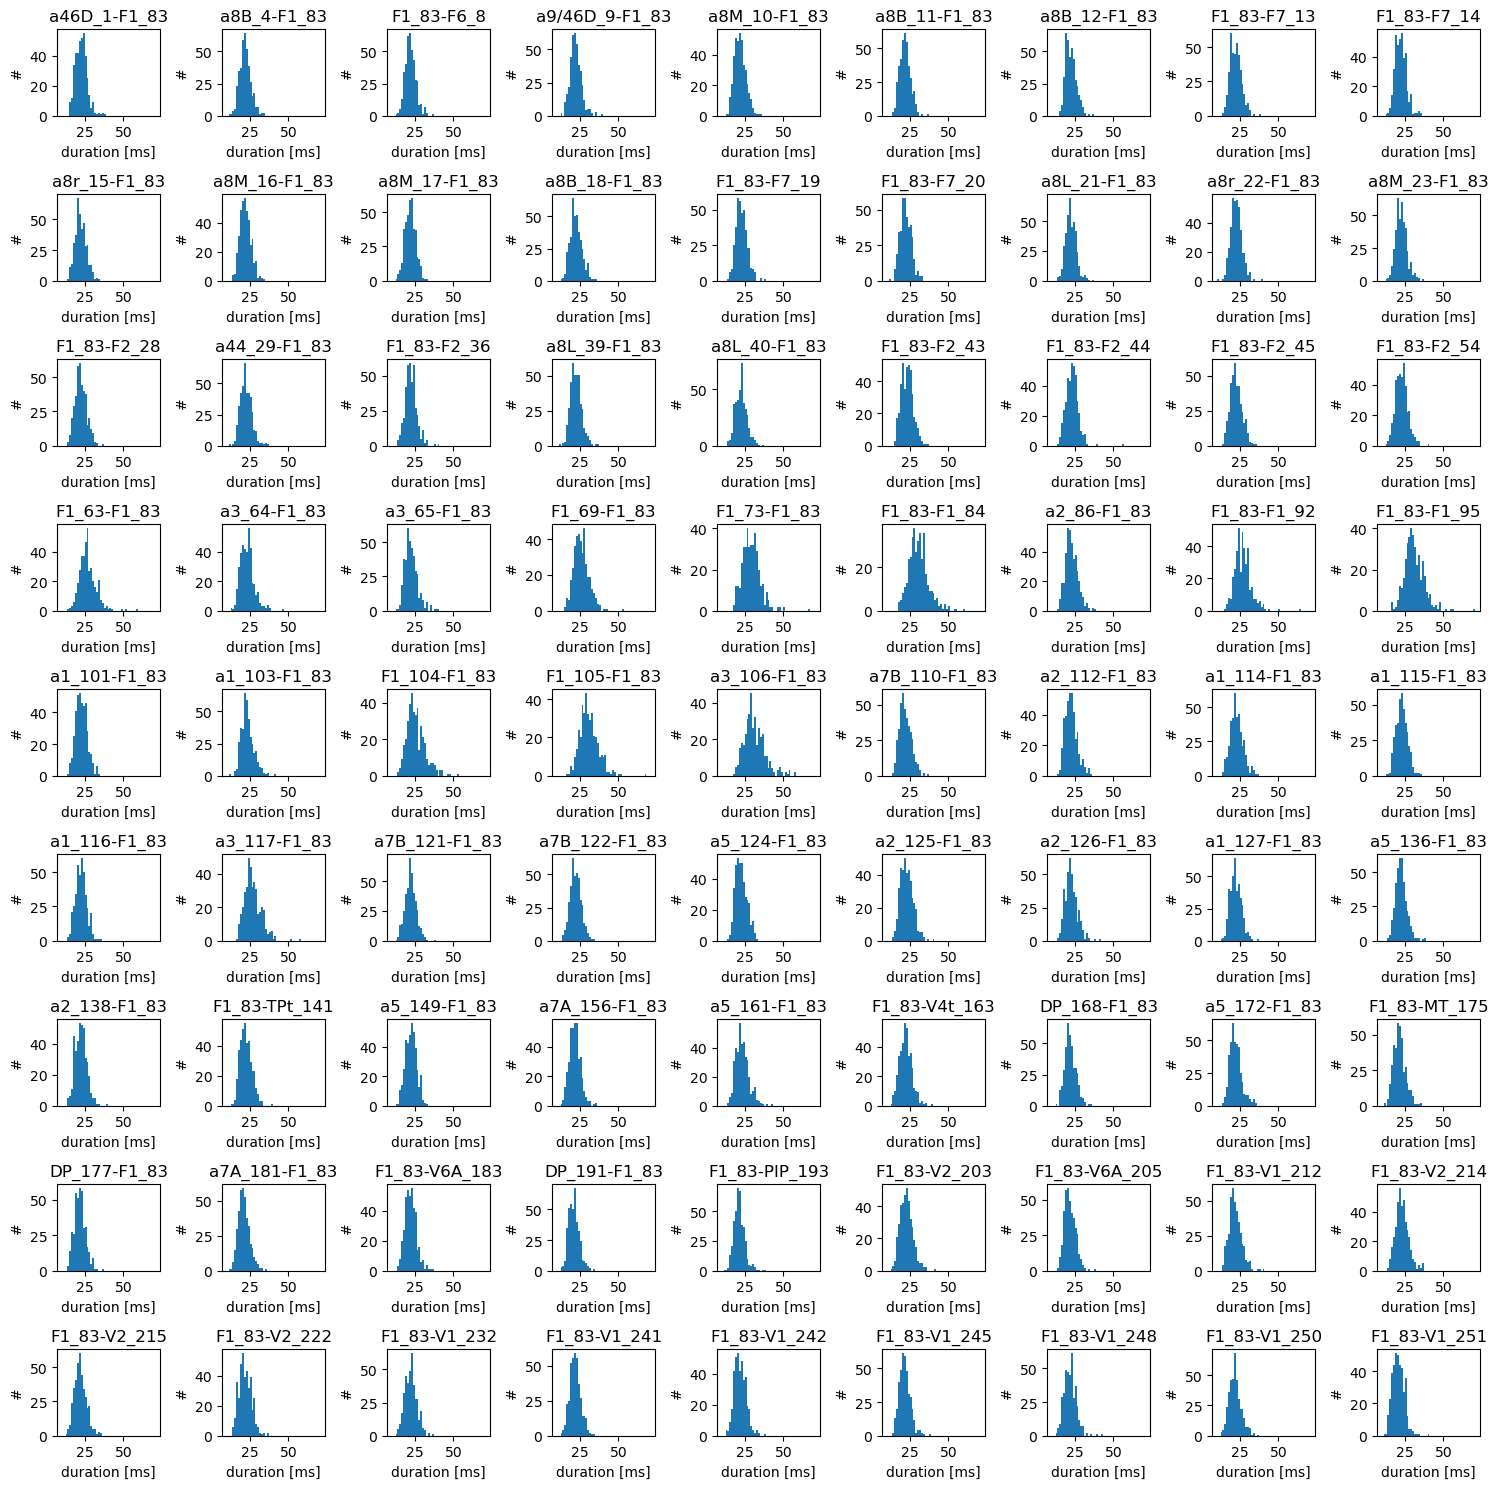

In [34]:
plt.figure(figsize=(15, 15))


bins = np.linspace(d.min(), d.max(), 50)

for pp, roi in enumerate(pec.roi.values):

    ax = plt.subplot(9, 9, pp + 1)

    plt.hist(d[:, pp], bins)
    plt.xlabel("duration [ms]")
    plt.ylabel("#")
    plt.title(roi)

plt.tight_layout()

plt.savefig(f"figures/band{band}/duration_distributions_F1_83_pairs.pdf")

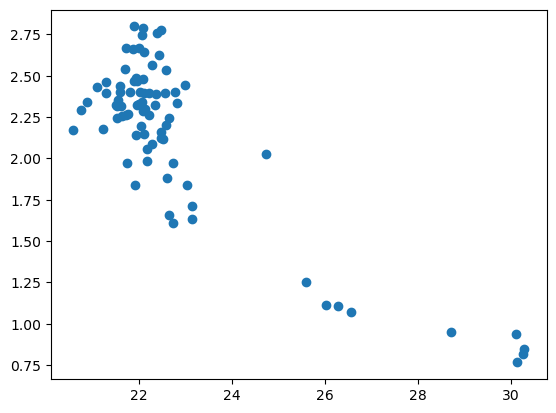

In [35]:
plt.scatter(d.median("trials"), sig)